In [1]:
!uv pip install -q --system numba-cuda==0.4.0
import numba.cuda as cuda
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
import matplotlib.pyplot as plt
import time
import numpy as np

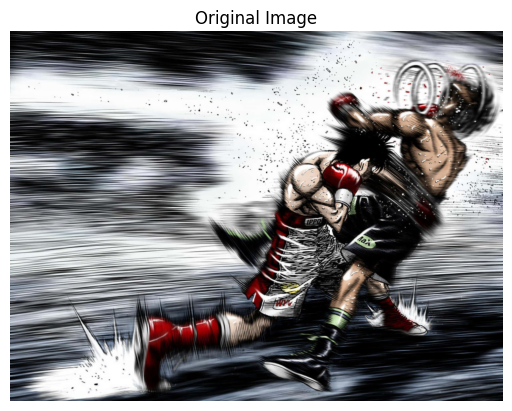

In [3]:
img = plt.imread('ippo.jpg')
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

In [4]:
print(img.shape)
compressed_img = img.reshape(img.shape[0]* img.shape[1], 3)
print(compressed_img.shape)

(1440, 1920, 3)
(2764800, 3)


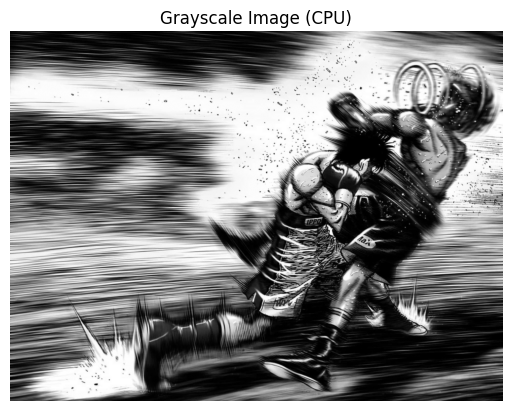

CPU grayscale time: 5.535660 s


In [5]:
def grayscale_cpu(rgb):
    gray = np.zeros(rgb.shape[0], dtype=np.float32)
    for i in range(rgb.shape[0]):
        r, g, b = rgb[i]
        gray[i] = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

if img.dtype == np.uint8:
    img = img.astype(np.float32) / 255

h, w, c = img.shape
pixels = h * w

rgb_flat = img.reshape(pixels, 3)

t0 = time.time()
gray_img = grayscale_cpu(rgb_flat)
t1 = time.time()

gray_img = gray_img.reshape(h, w)

plt.imshow(gray_img, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image (CPU)')
plt.show()

print(f"CPU grayscale time: {t1 - t0:.6f} s")

In [14]:
compressed_img = cuda.to_device(compressed_img)
block_size = 64
pixel_count = img.shape[0] * img.shape[1]
grid_size = int(pixel_count/block_size)

GPU runtime: 0.078662


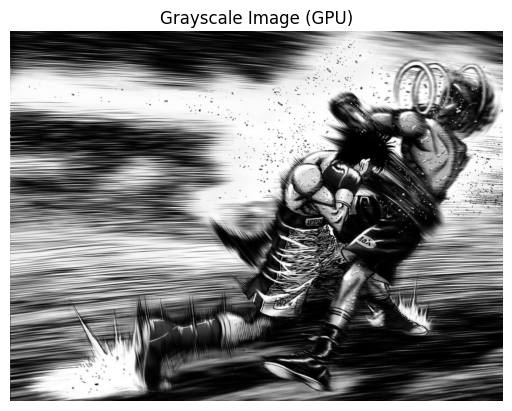

In [11]:
@cuda.jit
def grayscale_gpu(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3)
  dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

gray_img_cuda =  cuda.device_array((pixel_count, 1), dtype=np.uint8)
start = time.time()
grayscale_gpu[grid_size, block_size](compressed_img, gray_img_cuda)
end = time.time()

gray_img = gray_img_cuda.copy_to_host()
gray_img = gray_img.reshape(img.shape[0], img.shape[1], 1)
plt.title('Grayscale Image (GPU)')
plt.axis('off')
plt.imshow(gray_img, cmap="gray")
print(f"GPU runtime: {end - start:.6f}")

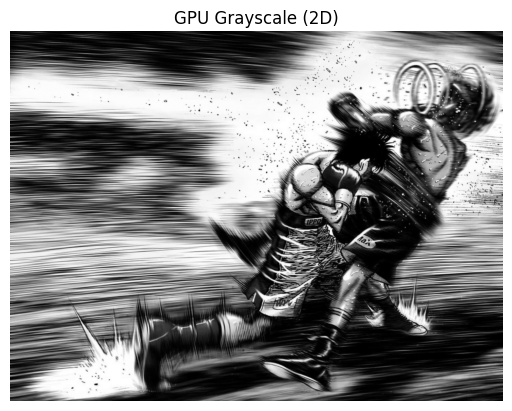

GPU runtime: 0.000371 s


In [15]:
@cuda.jit
def grayscale_gpu_2d(src, dst, width, height):
    x, y = cuda.grid(2)
    if x < width and y < height:
        r = src[y, x, 0]
        g = src[y, x, 1]
        b = src[y, x, 2]
        gray = (int(r) + int(g) + int(b)) // 3
        dst[y, x] = gray

if img.dtype != np.uint8:
    img = (img * 255).astype(np.uint8)

height, width = img.shape[0], img.shape[1]

src_device = cuda.to_device(img)
dst_device = cuda.device_array((height, width), dtype=np.uint8)

threads_per_block = (16, 16)
blocks_per_grid_x = int(np.ceil(width / threads_per_block[0]))
blocks_per_grid_y = int(np.ceil(height / threads_per_block[1]))
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

grayscale_gpu_2d[blocks_per_grid, threads_per_block](src_device, dst_device, width, height)
cuda.synchronize()

start_gpu = time.time()
grayscale_gpu_2d[blocks_per_grid, threads_per_block](src_device, dst_device, width, height)
cuda.synchronize()
end_gpu = time.time()
gpu_time = end_gpu - start_gpu

gray_gpu = dst_device.copy_to_host()

plt.imshow(gray_gpu, cmap='gray')
plt.title(f"GPU Grayscale (2D)")
plt.axis('off')

plt.show()

print(f"GPU runtime: {gpu_time:.6f} s")